In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

import numpy as np
import pandas as pd
np.random.seed(123)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

class DataSelector(BaseEstimator, TransformerMixin):
    """Select columns of numpy arrays based on attribute_indices."""

    def __init__(self, attribute_indices):
        self.attribute_indices = attribute_indices

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array(X)[:,self.attribute_indices]

In [3]:
original_data = pd.read_csv(
    "../../data/adult.data.txt", 
    names=["Age", "Workclass", "fnlwgt", "Education", "Education-Num", 
           "Marital Status", "Occupation", "Relationship", "Race", "Sex", 
           "Capital Gain", "Capital Loss", "Hours per week", "Country", "Target"],
    sep=r'\s*,\s*', engine='python', na_values="?")

In [4]:
# Order features (numeric first, categorical second) make life easier
feature_order = ['Age', 'Education-Num', 'Capital Gain',
                 'Capital Loss', 'Hours per week',
                 'Workclass', 'Education', 'Marital Status', 'Occupation',
                 'Relationship', 'Race', 'Sex', 'Country']
data = original_data[feature_order]

y = original_data['Target'] != '<=50K'

gender = original_data["Sex"] == 'Male'

In [5]:
data.head()

,Age,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass,Education,Marital Status,Occupation,Relationship,Race,Sex,Country
0,39,13,2174,0,40,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States
1,50,13,0,0,13,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
2,38,9,0,0,40,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States
3,53,7,0,0,40,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States
4,28,13,0,0,40,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba


In [6]:
# Define categorical names and indices
categorical_features = list(data.columns[5:])
categorical_idx = list(range(5, len(data.columns)))
continuous_features = list(data.columns[:5])
continuous_idx = list(range(0, 5))

X = data.values

# Get feature names and their values for categorical data (needed for LIME)
categorical_names = {}
for idx, feature in zip(categorical_idx, categorical_features):
    le = LabelEncoder()
    X[:, idx] = le.fit_transform(list(X[:, idx]))
    categorical_names[idx] = le.classes_

# To suppress a warning later (not strictly necessary)
X = X.astype(float)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, gender_train, gender_test = train_test_split(X, y,
                                                                               gender,
                                                                               train_size=0.8,
                                                                               random_state=1)

/Users/thead/anaconda/envs/adv-comp-18/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier


# A preprocessing pipeline that encodes categorical features
# and scales continous features.
continuous_pipeline = Pipeline([
    ('selector', DataSelector(continuous_idx)),
    ('scaler', StandardScaler()),
    ])

categorical_pipeline = Pipeline([
    ('selector', DataSelector(categorical_idx)),
    ('encoder', OneHotEncoder(sparse=False)),
    ])

preprocessing_pipeline = FeatureUnion(transformer_list=[
    ("continuous_pipeline", continuous_pipeline),
    ("categorical_pipeline", categorical_pipeline),
    ])

lr_pipe = make_pipeline(preprocessing_pipeline,
                        LogisticRegression())
rf_pipe = make_pipeline(preprocessing_pipeline, 
                        RandomForestClassifier(n_estimators=100))
rf_pipe = RandomForestClassifier(n_estimators=100, max_depth=6)

In [9]:
lr_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [10]:
lr_pipe.score(X_train, y_train)

0.8525030712530712

In [11]:
lr_pipe.score(X_test, y_test)

0.8509135575003839

In [12]:
rf_pipe.score(X_test, y_test)

0.8569015814524796

In [13]:
from lime.lime_tabular import LimeTabularExplainer


explainer = LimeTabularExplainer(
    X_train,
    class_names=['<=50k', '>50k'],
    feature_names=list(data.columns),
    categorical_features=categorical_idx,
    categorical_names=categorical_names,
    discretize_continuous=True
)

Probability of earning >50k: 0.3175


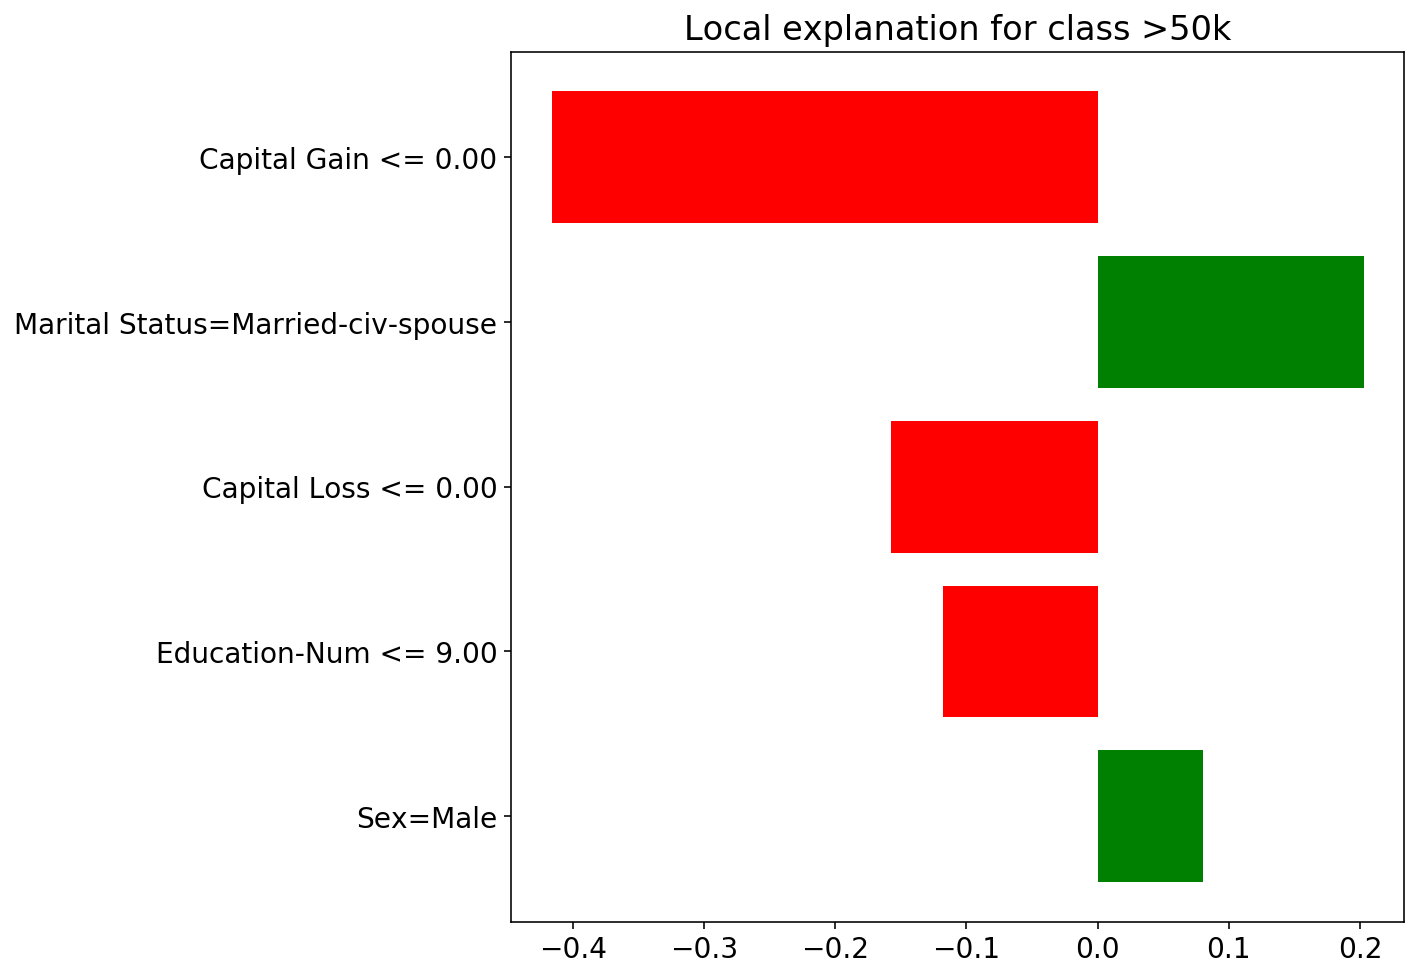

In [14]:
example = 3 #+9
exp = explainer.explain_instance(X_test[example],
                                 lr_pipe.predict_proba,
                                 num_features=5)
print('Probability of earning >50k: %.4f' % exp.predict_proba[1])
exp.as_pyplot_figure();

In [15]:
list(data.columns)

['Age',
 'Education-Num',
 'Capital Gain',
 'Capital Loss',
 'Hours per week',
 'Workclass',
 'Education',
 'Marital Status',
 'Occupation',
 'Relationship',
 'Race',
 'Sex',
 'Country']

In [16]:
X_test[example]

array([33.,  9.,  0.,  0., 40.,  3., 11.,  2.,  9.,  0.,  4.,  1., 38.])

Probability of earning >50k: 0.1652


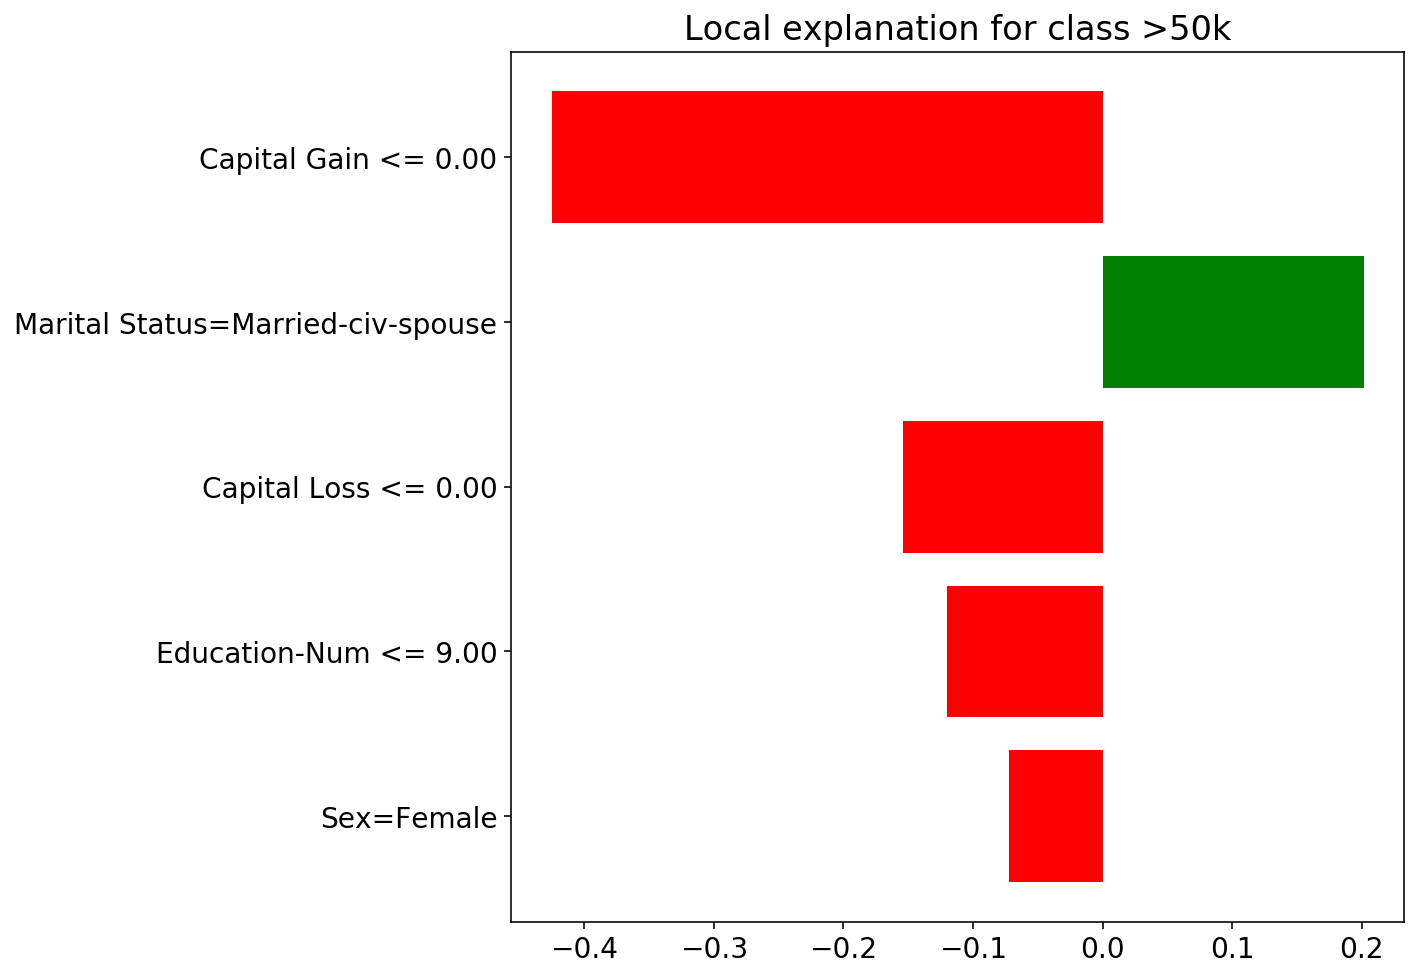

In [17]:
# what if we flip the gender?
x_hand_picked = np.array(X_test[example])
x_hand_picked[11] = 0
exp = explainer.explain_instance(x_hand_picked,
                                 lr_pipe.predict_proba,
                                 num_features=5)
print('Probability of earning >50k: %.4f' % exp.predict_proba[1])
exp.as_pyplot_figure();

Probability of earning >50k: 0.3176


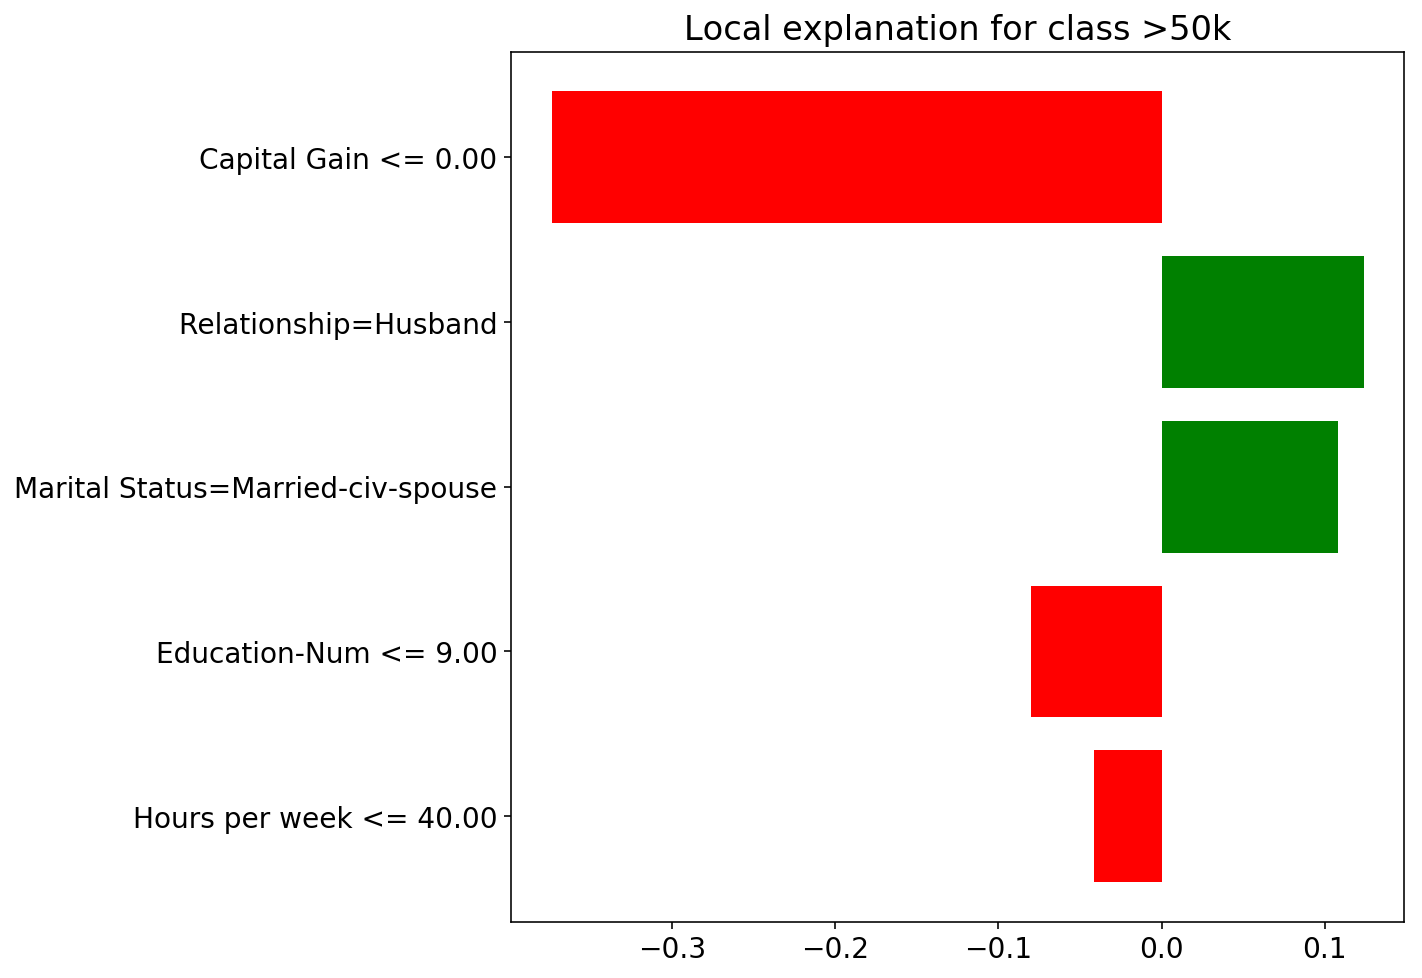

In [18]:
# Using a random forest instead
example = 3
x_hand_picked = np.array(X_test[example])
# work more hours?
#x_hand_picked[4] = 50 
exp = explainer.explain_instance(x_hand_picked,
                                 rf_pipe.predict_proba,
                                 num_features=5)
print('Probability of earning >50k: %.4f' % exp.predict_proba[1])
exp.as_pyplot_figure();

## Protected attributes

Does our model treat men and women the same?

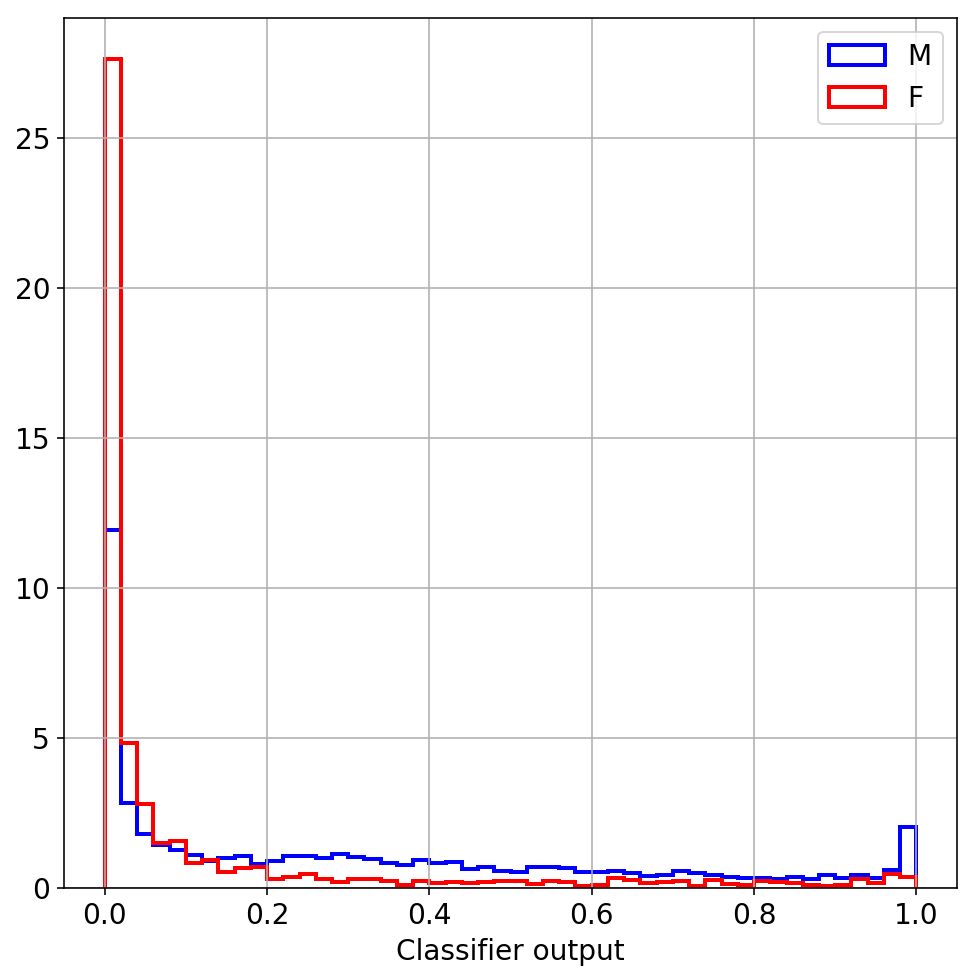

In [19]:
rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=1)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_test)[:, 1]

plt.hist(y_pred[gender_test == 1], bins=50, histtype="step",
         density=1, label="M", lw=2, color='b')
plt.hist(y_pred[gender_test == 0], bins=50, histtype="step",
         density=1, label="F", lw=2, color='r')
plt.legend()
plt.xlabel("Classifier output")
plt.grid();

In [20]:
# Remove the gender variable
feature_order = ['Age',
                 'Education-Num', 
                 'Capital Gain',
                 'Capital Loss', 'Hours per week',
                 'Workclass', 'Education', 'Marital Status', 'Occupation',
                 'Relationship', 'Race',
                 #'Sex',
                 'Country']
data = original_data[feature_order]

y_ng = original_data['Target'] != '<=50K'

# Define categorical names and indices
n_continous = 4
categorical_features = list(data.columns[n_continous:])
categorical_idx = list(range(n_continous, len(data.columns)))
continuous_features = list(data.columns[:n_continous])
continuous_idx = list(range(0, n_continous))

X_ng = data.values

for idx, feature in zip(categorical_idx, categorical_features):
    le = LabelEncoder()
    X_ng[:, idx] = le.fit_transform(list(X_ng[:, idx]))

# To suppress a warning later (not strictly necessary)
X_ng = X_ng.astype(float)

In [21]:
from sklearn.model_selection import train_test_split

X_trainNG, X_testNG, y_trainNG, y_testNG = train_test_split(X_ng, y_ng,
                                                            train_size=0.8,
                                                            random_state=1)

/Users/thead/anaconda/envs/adv-comp-18/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


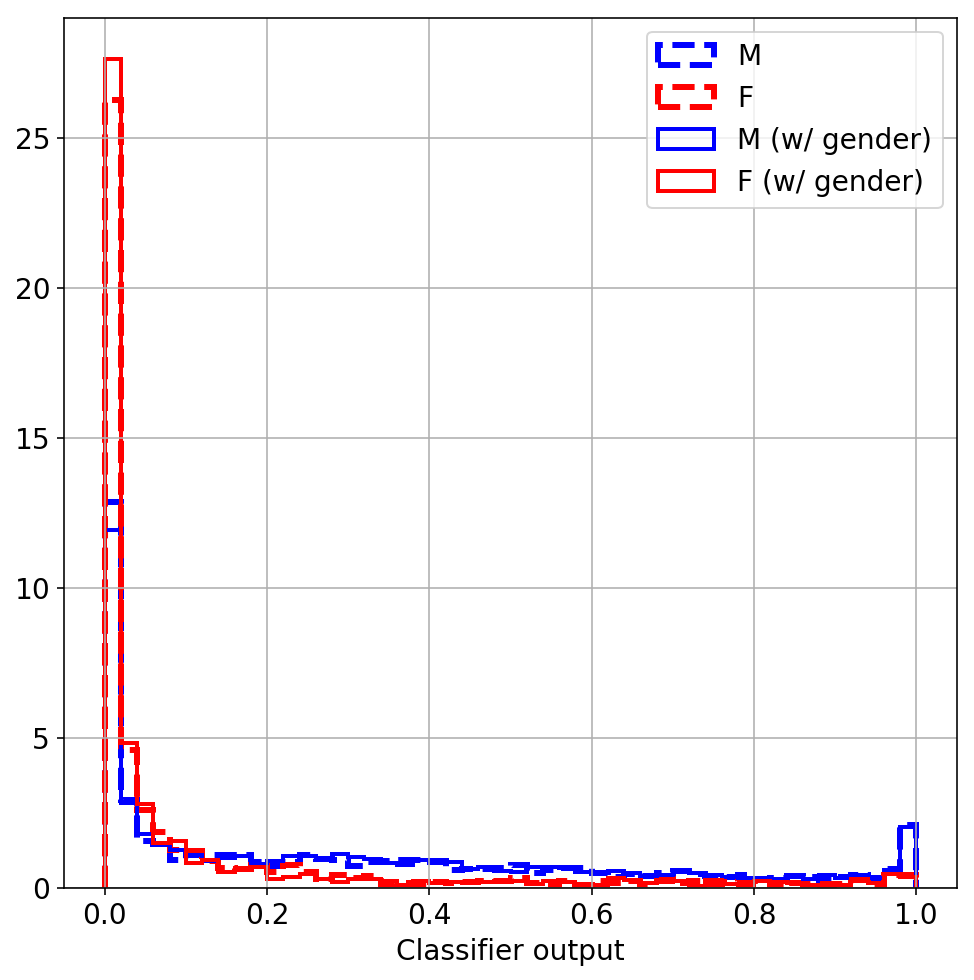

In [22]:
rf_ng = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=1)
rf_ng.fit(X_trainNG, y_trainNG)

y_predNG = rf_ng.predict_proba(X_testNG)[:, 1]

plt.hist(y_predNG[gender_test == 1], bins=50, histtype="step",
         density=1, label="M", lw=3, color='b', linestyle='--')
plt.hist(y_predNG[gender_test == 0], bins=50, histtype="step",
         density=1, label="F", lw=3, color='r', linestyle='--')

plt.hist(y_pred[gender_test == 1], bins=50, histtype="step",
         density=1, label="M (w/ gender)", lw=2, color='b')
plt.hist(y_pred[gender_test == 0], bins=50, histtype="step",
         density=1, label="F (w/ gender)", lw=2, color='r')
plt.legend()
plt.xlabel("Classifier output")
plt.grid();

In [35]:
x_hand_picked = np.array(X_test[example])
# female
x_hand_picked[11] = 0

rf.predict_proba([x_hand_picked])

array([[0.82559515, 0.17440485]])

In [34]:
# male
x_hand_picked[11] = 1

rf.predict_proba([x_hand_picked])

array([[0.73817165, 0.26182835]])

In [23]:
import shap

In [24]:
# load JS visualization code to notebook
shap.initjs() 


# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
shap_values = shap.TreeExplainer(rf_pipe).shap_values(X_test)

In [25]:
shap_values[1].shape

(6513, 14)

In [26]:
X_test.shape

(6513, 13)

In [27]:
# visualize explanation for our example's prediction
feature_names = list(data.columns)
shap.force_plot(shap_values[0][example, :], X_test[example,:],
                feature_names=feature_names)

In [28]:
rf_pipe.predict_proba([X_test[example,:]])

array([[0.6824221, 0.3175779]])

In [29]:
shap.force_plot(shap_values[0][:100, :], X_test[:100, :],
                feature_names=feature_names)

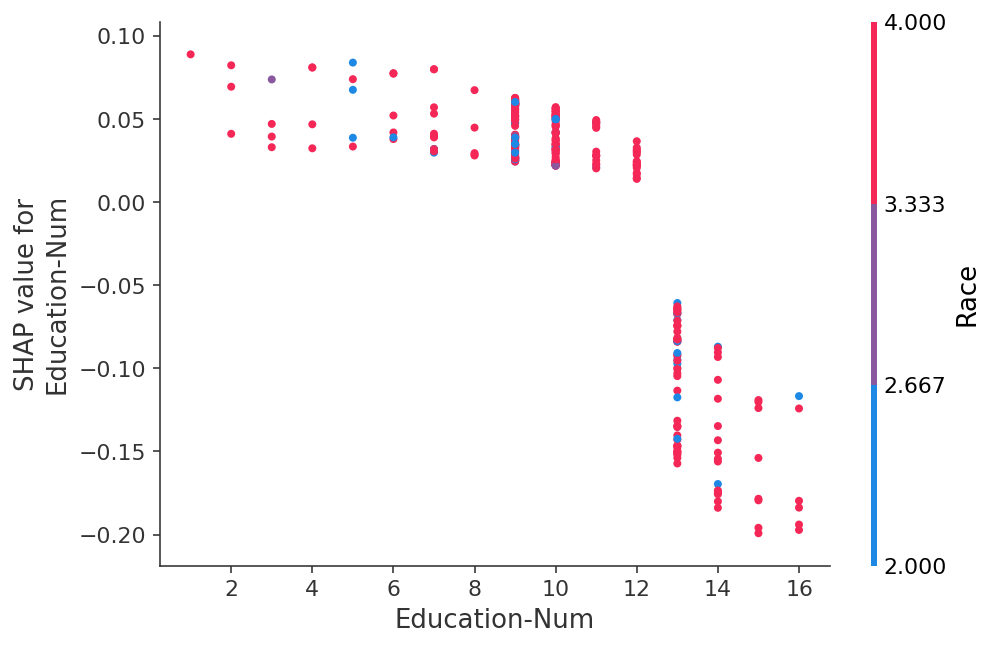

In [30]:
shap.dependence_plot(1, shap_values[0][:400, :], X_test[:400, :],
                     feature_names=feature_names,
                     interaction_index=10)

IndexError: list index out of range

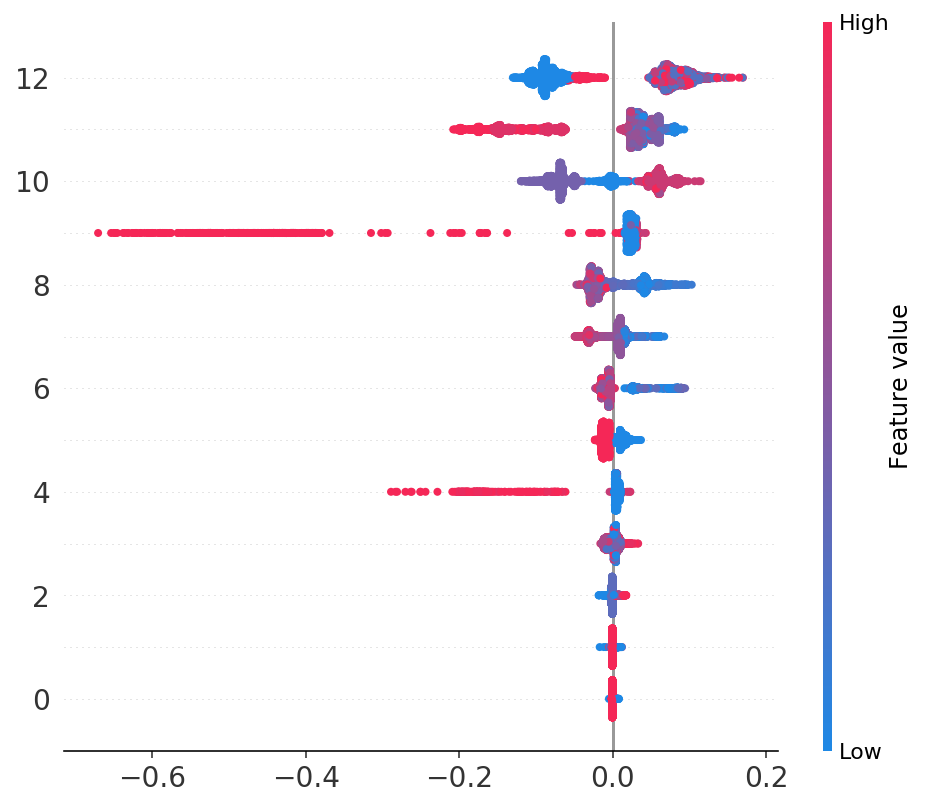

In [31]:
shap.summary_plot(shap_values[1], X_test,
                  feature_names=feature_names)

In [ ]:
categorical_names